## 다이나믹 프로그래밍

다이나믹 프로그래밍은 model-based 접근법으로, 환경의 전이 확률과 보상을 알고 있을 때 사용됩니다. 이번 코드에서는 DP 기법의 가치 이터레이션 (Value Iteration), 정책 이터레이션 (Policy Iteration)을 활용해 최적 정책을 찾습니다.

다음 환경(**GridWorldEnvironment**)을 가지고 가치 이터레이션, 정책 이터레이션을 구현하세요.

## GridWorldEnvironment
GridWorld는 격자 기반 환경으로, 에이전트가 상, 하, 좌, 우로 이동하며 목표 지점에 도달해야 합니다.

```py
start_point = (0,0) # 시작점
end_point = (4,4) # 목표 지점
gridworld_size = (5,5) # 5x5 크기의 격자
env = GridWorldEnvironment(start_point, end_point, grid_world_size)
```

## Original Code

In [27]:
import numpy as np
from typing import Tuple

class GridWorldEnvironment:
    def __init__(self, start_point:Tuple, end_point:Tuple, gridworld_size:Tuple):
        # 시작점과 끝점을 받는다.
        self.start_point = start_point
        self.end_point = end_point if end_point != (-1,-1) else (gridworld_size[0] + end_point[0],
                                                                 gridworld_size[1] + end_point[1])

        # 그리드 월드의 규격을 받는다.
        self.width, self.height = gridworld_size

        # action dictionary
        self.action_space = ['up', 'down', 'left', 'right']
        self.num_actions = len(self.action_space)
        self.actions = {'up':(-1,0),
                        'down':(1,0),
                        'left':(0,-1),
                        'right':(0,1) }

        # 상태 : 좌표로 나타남
        self.traces = []

        # total states
        self.total_states = []
        for x in range(self.width):
            for y in range(self.height):
                self.total_states.append((x,y))

        # reward
        self.reward = np.zeros(shape=(self.height, self.width)).tolist()
        self.reward[end_point[0]][end_point[1]] = 1.0

    def render(self, trajectory):
        # 그리드 월드의 상태를 출력한다.
        self.grid_world = np.full(shape=(self.height, self.width), fill_value=".").tolist()

        self.traces = trajectory
        last_point = self.traces[-1] # 에이전트가 가장 마지막에 있었던 위치
        traces = list(set(self.traces)) # 중복된 값을 삭제하기 위함
        for trace in traces:
            self.grid_world[trace[0]][trace[1]] = "X"

        self.grid_world[self.start_point[0]][self.start_point[1]] = "S" # start point
        self.grid_world[self.end_point[0]][self.end_point[1]] = "G" # end point
        self.grid_world[last_point[0]][last_point[1]] = "A" # 현재 에이전트의 위치

        # string으로 출력한다.
        grid = ""

        for i in range(self.height):
            for j in range(self.width):
                grid += self.grid_world[i][j]+" "
            grid += "\n"

        print(grid)

    def get_reward(self, state, action_idx):
        next_state = self.state_after_action(state, action_idx)
        return self.reward[next_state[0]][next_state[1]]

    def state_after_action(self, state, action_idx:int):
        action = self.action_space[action_idx]
        row_movement, col_movement = self.actions[action]

        # action에 따라 에이전트 이동
        next_state = (state[0]+row_movement, state[1]+col_movement)
        next_state = self.check_boundary(next_state)

        return next_state

    def check_boundary(self, state):
        state = list(state)
        state[0] = (0 if state[0] < 0 else self.height - 1 if state[0] > self.height - 1 else state[0])
        state[1] = (0 if state[1] < 0 else self.width - 1 if state[1] > self.width - 1 else state[1])
        return tuple(state)

## Own Code
위 환경 클래스를 상속 받아 `env.render` 코드를 구현하세요.

In [28]:
class inherit_env(GridWorldEnvironment):
    def render(self, trajectory):
        # 그리드 월드의 상태를 출력한다.
        self.grid_world = np.full(shape=(self.height, self.width), fill_value=".").tolist()

        self.traces = trajectory
        last_point = self.traces[-1] # 에이전트가 가장 마지막에 있었던 위치
        traces = list(set(self.traces)) # 중복된 값을 삭제하기 위함
        for trace in traces:
            self.grid_world[trace[0]][trace[1]] = "X"

        self.grid_world[self.start_point[0]][self.start_point[1]] = "S" # start point
        self.grid_world[self.end_point[0]][self.end_point[1]] = "G" # end point
        self.grid_world[last_point[0]][last_point[1]] = "A" # 현재 에이전트의 위치

        # string으로 출력한다.
        grid = ""
        for i in range(self.height):
            for j in range(self.width):
                grid += self.grid_world[i][j]+" "
            grid += "\n"
        print(f"Trajectory")
        print(grid)
        
        reward = ""
        for i in range(self.height):
            for j in range(self.width):
                reward += f"{self.reward[i][j]} "
            reward += "\n"
        print(f"Reward of GridWorld")
        print(reward)


In [29]:
env = inherit_env((0, 0), (4, 4), (5, 5))
trajectory = [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (1, 4), (2, 4), (3, 4), (4, 4)]
env.render(trajectory)

Trajectory
S X X X X 
. . . . X 
. . . . X 
. . . . X 
. . . . A 

Reward of GridWorld
0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 1.0 



# 01. 정책 이터레이션
정책 이터레이션은 정책 평가와 정책 개선을 번갈아 수행하며 최적 정책을 찾아가는 방법입니다.

- 스켈레톤 코드  
`init` 부를 제외한 나머지 매소드를 채워주세요.

1. get_policy : 현재 상태에서의 정책 반환
2. get_value	: 현재 상태의 가치 반환
3. get_action : 현재 정책에 따라 행동 선택
4. policy_evaluation : 정책을 기준으로 가치 함수 업데이트
5. policy_improvement : 가치 함수를 이용해 최적 정책을 찾음

In [30]:
class PolicyIteration:
    def __init__(self,env):
        # about env
        self.env = env
        self.action_space = env.action_space # ['up', 'down', 'left', 'right'] 차례대로 (-1,0) (1,0) (0,-1) (0,1)
        self.num_action = len(self.action_space)

        # value 2d list
        self.value_table = np.zeros(shape = (env.height, env.width)).tolist() # Appendix 1

        # 상하좌우 동일한 확률을 가지는 정책으로 초기화
        self.policy_table = np.full(shape = (env.height, env.width, self.num_action), fill_value = 1/self.num_action).tolist()

        # end state 에서는 어떠한 행동도 할 필요가 없어서 policy table을 비운다.
        self.policy_table[env.end_point[0]][env.end_point[1]] = []

        self.gamma = 0.9 # 할인율

    def get_policy(self, state):
        if state == self.env.end_point:
            return "Goal"
        return self.policy_table[state[0]][state[1]] # 요소가 4개인 리스트 반환

    def get_value(self, state):
        return self.value_table[state[0]][state[1]] # 스칼라 반환

    def get_action(self,state):
        policy = self.get_policy(state)
        action_idx = np.random.choice(range(len(self.action_space)), p=policy)
        return action_idx
    
    def policy_evaluation(self):
        for state in self.env.total_states:
            value = 0.0
            if state == self.env.end_point:
                self.value_table[state[0]][state[1]] = 0.0
            else:
                state_policy = self.get_policy(state)
                for action_idx in range(self.num_action):
                    next_state = self.env.state_after_action(state, action_idx)
                    next_value = self.get_value(next_state)
                    reward = self.env.get_reward(state, action_idx)
                    value += state_policy[action_idx]*(reward + self.gamma*next_value) # 벨만 기대 방정식
                self.value_table[state[0]][state[1]] = value

    def policy_improvement(self):
        new_policy = self.policy_table
        for state in self.env.total_states:
            q_values = []
            policy = np.zeros(shape=(self.num_action)).tolist()
            for action_idx in range(self.num_action):
                next_state = self.env.state_after_action(state, action_idx)
                next_value = self.get_value(next_state)
                reward = self.env.get_reward(state, action_idx)
                q_value = reward + self.gamma*next_value
                q_values.append(q_value)
            
            max_q_value = np.max(q_values)
            max_indices = np.where(q_values == max_q_value)[0]

            prob = 1/len(max_indices)

            for idx in max_indices:
                policy[idx] = prob
            
            new_policy[state[0]][state[1]] = policy
        self.policy_table = new_policy


## 정책 이터레이션 실행
정의한 클래스를 이용해 정책 이터레이션을 실행해 주세요.

## 학습에서 중요한 정보
학습이 되고 있는 것을 판단할 수 있는 파라미터를 찾아 시각화해 주세요.

In [31]:
if __name__ == "__main__":
    env = GridWorldEnvironment((0, 0), (4, 4), (5, 5))
    agent = PolicyIteration(env)

    max_iteration = 1000
    delta = 0
    threshold = 1e-7
    iteration = 0
    RENDER = True

    # 학습 파라미터 시각화
    delta_history = [delta]
    value_history = [agent.value_table] # 초기 가치 함수 테이블을 저장
    mean_value_history = [np.mean(agent.value_table)]
    max_value_history = [np.max(agent.value_table)]
    policy_history = [agent.policy_table] # 초기 정책 테이블을 저장

    while iteration < max_iteration:
        old_value = np.array(agent.value_table)
        agent.policy_evaluation() # 새로운 가치 함수 계산
        agent.policy_improvement() # 정책 업데이트 
        new_value = np.array(agent.value_table) # 새로운 가치 함수 테이블
        delta = np.max(np.abs(new_value - old_value)) # 최대 변화량

        delta_history.append(delta)
        value_history.append(new_value.tolist())
        mean_value_history.append(np.mean(new_value))
        max_value_history.append(np.max(new_value))
        policy_history.append(agent.policy_table)

        if delta < threshold:
            break
        
        iteration += 1
    
    # delta
    for i in range(len(delta_history)):
        print(f"iteration {i}: {delta_history[i]:.4f}")

    # total iteration
    print("-------------------------------------------")
    print(f"the number of iteration util convergence: {iteration}")
    
    # 최종 가치 테이블
    print("\n\nFinal value table")
    value = ""
    for row in range(env.height):
        for col in range(env.width):
            value += f"{value_history[-1][row][col]:.2f} "
        value += "\n"
    print(value)

    # 최종 정책 테이블
    print("\nFinal policy table")
    policy = ""
    for state in env.total_states:
        policy = agent.get_policy(state)
        print(f"state {state}: {policy}")

    # 정책 시각화
    print("\nFinal policy rendering")
    path = np.full(shape=(env.height, env.width), fill_value="").tolist()
    action_arrow = {0:'↑', 
                    1:'↓', 
                    2: '←', 
                    3: '→'}
    for state in env.total_states:
        policy = agent.get_policy(state)
        if state == env.end_point:
            continue
        policy = np.array(policy, dtype=float)
        max_indices = np.where(policy == np.max(policy))[0].tolist()
        for idx in max_indices:
            path[state[0]][state[1]] += action_arrow[idx]
    
    policy = ""
    for row in range(env.height):
        for col in range(env.width):
            policy += f"{path[row][col]} "
        policy += '\n'
    
    print(policy)

    # 정책을 따랐을 때 실제 trajectory
    trajectory = [env.start_point]
    state = env.start_point
    while state != env.end_point:
        action_idx = agent.get_action(state)
        next_state = env.state_after_action(state, action_idx)
        state = next_state
        trajectory.append(state)   
    print(f"trajectory: {trajectory}")     

    # 최종 trajectory rendering
    print(f"\nTrajectory Rendering")
    if RENDER:
        env.render(trajectory=trajectory)

iteration 0: 0.0000
iteration 1: 0.2500
iteration 2: 0.7500
iteration 3: 0.6750
iteration 4: 0.6075
iteration 5: 0.5468
iteration 6: 0.4921
iteration 7: 0.4429
iteration 8: 0.3986
iteration 9: 0.3587
iteration 10: 0.0000
-------------------------------------------
the number of iteration util convergence: 9


Final value table
0.48 0.53 0.59 0.66 0.73 
0.53 0.59 0.66 0.73 0.81 
0.59 0.66 0.73 0.81 0.90 
0.66 0.73 0.81 0.90 1.00 
0.73 0.81 0.90 1.00 0.00 


Final policy table
state (0, 0): [0.0, 0.5, 0.0, 0.5]
state (0, 1): [0.0, 0.5, 0.0, 0.5]
state (0, 2): [0.0, 0.5, 0.0, 0.5]
state (0, 3): [0.0, 0.5, 0.0, 0.5]
state (0, 4): [0.0, 1.0, 0.0, 0.0]
state (1, 0): [0.0, 0.5, 0.0, 0.5]
state (1, 1): [0.0, 0.5, 0.0, 0.5]
state (1, 2): [0.0, 0.5, 0.0, 0.5]
state (1, 3): [0.0, 0.5, 0.0, 0.5]
state (1, 4): [0.0, 1.0, 0.0, 0.0]
state (2, 0): [0.0, 0.5, 0.0, 0.5]
state (2, 1): [0.0, 0.5, 0.0, 0.5]
state (2, 2): [0.0, 0.5, 0.0, 0.5]
state (2, 3): [0.0, 0.5, 0.0, 0.5]
state (2, 4): [0.0, 1.0, 0.0, 

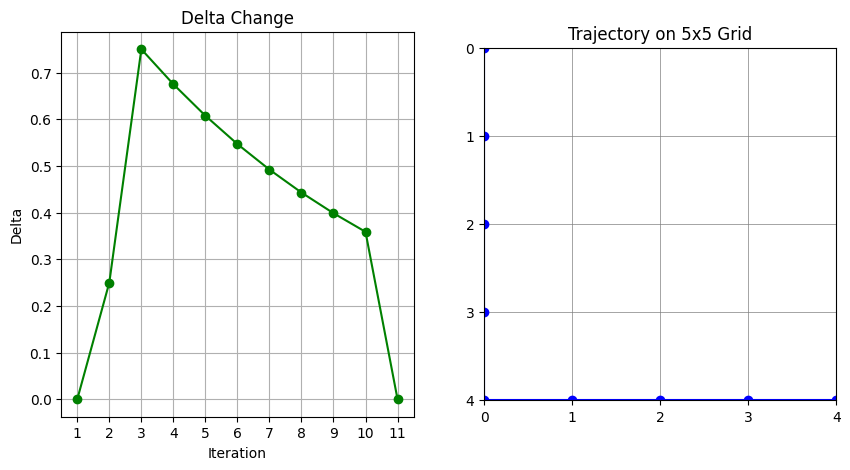

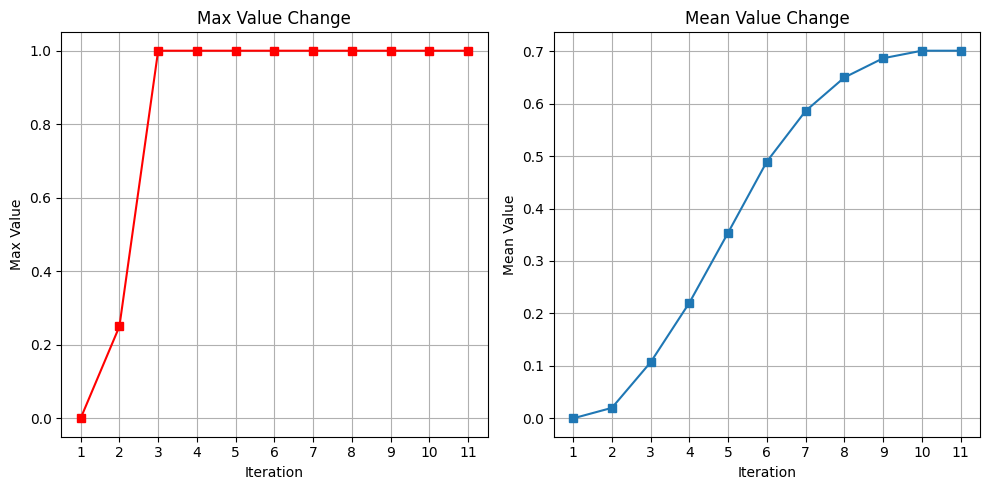

In [32]:
import matplotlib.pyplot as plt

# iteration에 따른 delta의 변화
iterations = list(range(1, len(delta_history) + 1))
x_vals = [trace[0] for trace in trajectory]
y_vals = [trace[1] for trace in trajectory]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 가로로 나란히

# Delta 변화
axes[0].plot(iterations, delta_history, marker='o', linestyle='-', color = 'green')
axes[0].set_title('Delta Change')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Delta')
axes[0].grid(True)
axes[0].set_xticks(iterations)

# 격자판 그리기
for i in range(6):
    axes[1].plot([0, 4], [i, i], color='gray', linewidth=0.5)
    axes[1].plot([i, i], [0, 4], color='gray', linewidth=0.5)

# Trajectory 경로 그리기
axes[1].plot(x_vals, y_vals, marker='o', linestyle='-', color='blue')

# 축 설정
axes[1].set_xlim(0, 4)
axes[1].set_ylim(0, 4)
axes[1].set_xticks(range(5))
axes[1].set_yticks(range(5))
axes[1].set_aspect('equal')
axes[1].invert_yaxis()  # (0,0)이 좌상단으로 오도록

plt.title("Trajectory on 5x5 Grid")
plt.grid(False)
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 가로로 나란히

# Max Value 변화
axes[0].plot(iterations, max_value_history, marker='s', linestyle='-', color='red')
axes[0].set_title('Max Value Change')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Max Value')
axes[0].grid(True)
axes[0].set_xticks(iterations)

# Max Mean 변화
axes[1].plot(iterations, mean_value_history, marker='s', linestyle='-')
axes[1].set_title('Mean Value Change')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Mean Value')
axes[1].grid(True)
axes[1].set_xticks(iterations)


plt.tight_layout()
plt.show()


# 02. 가치 이터레이션
가치 이터레이션은 정책 없이 직접 가치 함수를 최적화하는 방법입니다.
- 스켈레톤 코드  
`init` 부를 제외한 나머지 매소드를 채워주세요.
1. value_iteration : 벨만 최적 방정식을 이용해 가치 함수를 반복적으로 업데이트
2. get_value : 현재 상태의 가치를 반환
3. get_action : 현재 가치 함수 기준으로 최적 행동 선택

In [33]:
class ValueIteration:
    def __init__(self, env):

        self.env = env
        self.action_space = env.action_space
        self.num_actions = env.num_actions

        # value 2d list
        self.value_table = np.zeros(shape=(env.height, env.width)).tolist()

        self.gamma = 0.9 # 할인율

    def value_iteration(self):
        for state in self.env.total_states:
            if state == self.env.end_point:
                self.value_table[state[0]][state[1]] = 0.0
            else:
                q_values = []
                # 벨만 최적 방정식
                for action_idx in range(self.num_actions):
                    next_state = self.env.state_after_action(state, action_idx)
                    next_value = self.get_value(next_state)
                    reward = self.env.get_reward(state, action_idx)
                    q_value = reward + self.gamma*next_value
                    q_values.append(q_value)
                max_q_value = np.max(q_values) # 최대의 큐함수값으로 가치 함수 업데이트
                self.value_table[state[0]][state[1]] = max_q_value
    '''
    정책 이터레이션과는 다르게 가치 함수를 계산하는 과정만 있지 정책을 업데이트하는 정책 발전 과정은 없다. 
    '''

    def get_action(self, state):
        # 정책 없이 가장 높은 큐함수를 가지는 행동을 반환해야 함
        if state == self.env.end_point:
            return []
        else:
            q_values = []
            for action_idx in range(self.num_actions):
                next_state = self.env.state_after_action(state, action_idx)
                next_value = self.get_value(next_state)
                reward = self.env.get_reward(state, action_idx)
                q_value = reward + self.gamma*next_value
                q_values.append(q_value)
            max_q_value = np.max(q_values)
            max_indices = np.where(q_values == max_q_value)[0]
            # print(max_indices) # np.array
        return list(max_indices) # 최대 큐함수를 가지는 행동의 인덱스 반환

    def get_value(self, state):
        return self.value_table[state[0]][state[1]]

## 가치 이터레이션 실행
정의한 클래스를 이용해 정책 이터레이션을 실행해 주세요.

## 학습에서 중요한 정보
학습이 되고 있는 것을 판단할 수 있는 파라미터/요소를 찾아 시각화해 주세요.

In [34]:
if __name__ == "__main__":
    env = GridWorldEnvironment((0, 0), (4, 4), (5, 5))
    agent = ValueIteration(env)

    max_iteration = 1000
    delta = 0
    threshold = 1e-7
    iteration = 0
    RENDER = True

    # 학습 파라미터 시각화
    delta_history = [delta]
    value_history = [agent.value_table] # 초기 가치 함수 테이블을 저장
    mean_value_history = [np.mean(agent.value_table)]
    max_value_history = [np.max(agent.value_table)]

    while iteration < max_iteration:
        old_value = np.array(agent.value_table)
        agent.value_iteration() # 새로운 가치 함수 계산
        new_value = np.array(agent.value_table) # 새로운 가치 함수 테이블
        delta = np.max(np.abs(new_value - old_value)) # 최대 변화량

        delta_history.append(delta)
        value_history.append(new_value.tolist())
        mean_value_history.append(np.mean(new_value))
        max_value_history.append(np.max(new_value))

        if delta < threshold:
            break
        
        iteration += 1
    
    # delta
    for i in range(len(delta_history)):
        print(f"iteration {i}: {delta_history[i]:.4f}")

    # total iteration
    print("-------------------------------------------")
    print(f"the number of iteration util convergence: {iteration}")
    
    # 최종 가치 테이블
    print("\n\nFinal value table")
    value = ""
    for row in range(env.height):
        for col in range(env.width):
            value += f"{value_history[-1][row][col]:.2f} "
        value += "\n"
    print(value)

    # 최종 정책 테이블 (학습 완료 후의 정책)
    print("\nFinal policy table")
    final_policy = np.zeros(shape=(env.height, env.width, env.num_actions)).tolist()
    for state in env.total_states:
        if state == env.end_point:
            print(f"state {state}: Goal")
        else:
            max_actions = agent.get_action(state) # 가장 높은 큐함수를 가지는 행동 인덱스 리스트를 반환
            prob = 1/len(max_actions)
            for action in max_actions:
                final_policy[state[0]][state[1]][action] = prob      
            print(f"state {state}: {final_policy[state[0]][state[1]]}")

    # 정책 시각화
    print("\nFinal policy rendering")
    path = np.full(shape=(env.height, env.width), fill_value="").tolist()
    action_arrow = {0:'↑', 
                    1:'↓', 
                    2: '←', 
                    3: '→'}
    for state in env.total_states:
        if state == env.end_point:
            continue
        else:
            max_prob = np.max(final_policy[state[0]][state[1]])
            max_indices = np.where(final_policy[state[0]][state[1]] == max_prob)[0]
            for idx in max_indices:
                path[state[0]][state[1]] += action_arrow[idx]
    
    rendering = ""
    for row in range(env.height):
        for col in range(env.width):
            rendering += f"{path[row][col]} "
        rendering += '\n'
    
    print(rendering)

    # 정책을 따랐을 때 실제 trajectory
    trajectory = [env.start_point]
    state = env.start_point
    while state != env.end_point:
        max_actions = agent.get_action(state) # 가장 큰 정책을 가지는 행동 인덱스 리스트
        action_idx = np.random.choice(max_actions)
        next_state = env.state_after_action(state, action_idx)
        state = next_state
        trajectory.append(state)   
    print(f"trajectory: {trajectory}")    

    if RENDER:
        env.render(trajectory=trajectory) 

iteration 0: 0.0000
iteration 1: 1.0000
iteration 2: 0.9000
iteration 3: 0.8100
iteration 4: 0.7290
iteration 5: 0.6561
iteration 6: 0.5905
iteration 7: 0.5314
iteration 8: 0.4783
iteration 9: 0.0000
-------------------------------------------
the number of iteration util convergence: 8


Final value table
0.48 0.53 0.59 0.66 0.73 
0.53 0.59 0.66 0.73 0.81 
0.59 0.66 0.73 0.81 0.90 
0.66 0.73 0.81 0.90 1.00 
0.73 0.81 0.90 1.00 0.00 


Final policy table
state (0, 0): [0.0, 0.5, 0.0, 0.5]
state (0, 1): [0.0, 0.5, 0.0, 0.5]
state (0, 2): [0.0, 0.5, 0.0, 0.5]
state (0, 3): [0.0, 0.5, 0.0, 0.5]
state (0, 4): [0.0, 1.0, 0.0, 0.0]
state (1, 0): [0.0, 0.5, 0.0, 0.5]
state (1, 1): [0.0, 0.5, 0.0, 0.5]
state (1, 2): [0.0, 0.5, 0.0, 0.5]
state (1, 3): [0.0, 0.5, 0.0, 0.5]
state (1, 4): [0.0, 1.0, 0.0, 0.0]
state (2, 0): [0.0, 0.5, 0.0, 0.5]
state (2, 1): [0.0, 0.5, 0.0, 0.5]
state (2, 2): [0.0, 0.5, 0.0, 0.5]
state (2, 3): [0.0, 0.5, 0.0, 0.5]
state (2, 4): [0.0, 1.0, 0.0, 0.0]
state (3, 0): [0

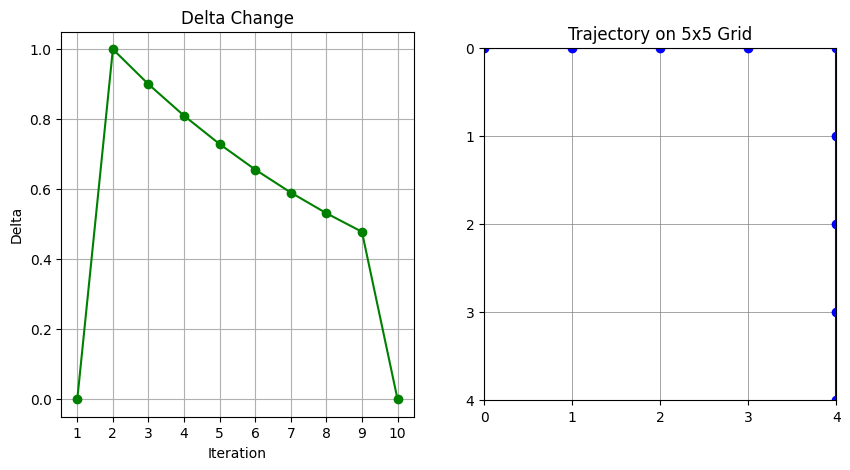

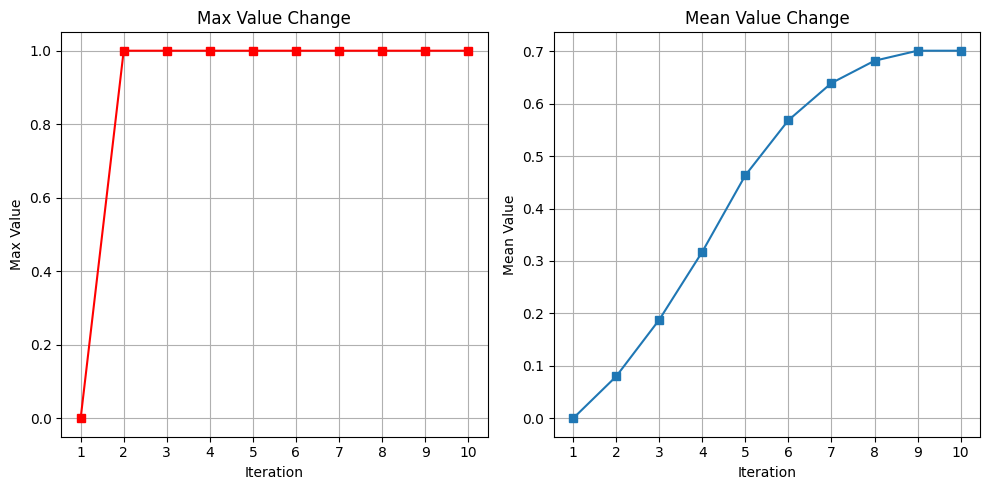

In [35]:
import matplotlib.pyplot as plt

# iteration에 따른 delta의 변화
iterations = list(range(1, len(delta_history) + 1))
x_vals = [trace[0] for trace in trajectory]
y_vals = [trace[1] for trace in trajectory]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 가로로 나란히

# Delta 변화
axes[0].plot(iterations, delta_history, marker='o', linestyle='-', color = 'green')
axes[0].set_title('Delta Change')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Delta')
axes[0].grid(True)
axes[0].set_xticks(iterations)

# 격자판 그리기
for i in range(6):
    axes[1].plot([0, 4], [i, i], color='gray', linewidth=0.5)
    axes[1].plot([i, i], [0, 4], color='gray', linewidth=0.5)

# Trajectory 경로 그리기
axes[1].plot(x_vals, y_vals, marker='o', linestyle='-', color='blue')

# 축 설정
axes[1].set_xlim(0, 4)
axes[1].set_ylim(0, 4)
axes[1].set_xticks(range(5))
axes[1].set_yticks(range(5))
axes[1].set_aspect('equal')
axes[1].invert_yaxis()  # (0,0)이 좌상단으로 오도록

plt.title("Trajectory on 5x5 Grid")
plt.grid(False)
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 가로로 나란히

# Max Value 변화
axes[0].plot(iterations, max_value_history, marker='s', linestyle='-', color='red')
axes[0].set_title('Max Value Change')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Max Value')
axes[0].grid(True)
axes[0].set_xticks(iterations)

# Max Mean 변화
axes[1].plot(iterations, mean_value_history, marker='s', linestyle='-')
axes[1].set_title('Mean Value Change')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Mean Value')
axes[1].grid(True)
axes[1].set_xticks(iterations)


plt.tight_layout()
plt.show()
